In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import keras
import tensorflow as tf

from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import array
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import metrics
from tensorflow.keras.layers import LeakyReLU, PReLU
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
# Load the dataset
dataset = r"D:\Documents\MASTER OF DATA SCIENCE\Research Project\Dataset\FILTERED DATASET.xlsx"
df = pd.read_excel(dataset).reset_index(drop=True)
df

,Power Generation (MW),Minimum Temperature (deg C),Mean Temperature (deg C),Mean Dew Point Temperature (dec C),Hargreaves Potential Evaporation (mm),Eastward Wind Component (m/s),Northward Wind Component (m/s),Surface Pressure (kPa)
0,1847,20.4186,24.1509,20.9383,4.0378,-0.9421,-1.2926,95.6548
1,1699,20.4468,24.5799,21.4949,3.7165,-0.4366,-1.5451,95.6191
2,1668,21.1208,22.0480,21.7623,1.6610,1.1046,-0.7552,95.5730
3,1669,20.2266,23.2253,21.2197,3.4360,0.5259,0.7888,95.5504
4,1689,20.7932,25.4247,21.8802,4.4191,-0.2299,-0.0105,95.5036
...,...,...,...,...,...,...,...,...
1819,3955,22.9583,25.0181,21.7488,3.2672,-1.7013,-0.7252,95.6364
1820,4666,23.6170,25.2186,22.6705,3.2683,-0.9600,-0.6435,95.5059
1821,12846,23.6043,25.6189,23.2253,3.2630,-1.0609,-0.4708,95.4480
1822,15627,22.5392,24.9505,23.0528,3.3393,-0.7917,-0.2790,95.4798


In [3]:
# # #Separate dates for future plotting
# # train_dates = pd.to_datetime(df['Day'])

# # Include only numerical variables
# numeric_df = df.select_dtypes(include=['number']).drop(['Year'], axis='columns', inplace=False)

In [4]:
# numeric_df

In [5]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df)

In [6]:
features = data_scaled[:, 1:]
target = data_scaled[:,0]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# # Reshape the target
# y_train = y_train.reshape(len(y_train), 1)
# y_test = y_test.reshape(len(y_test), 1)

# time_series = TimeSeriesSplit()
# # print(time_series)
# for train_index, test_index in time_series.split(features):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = features[train_index], features[test_index]
#     y_train, y_test = target[train_index], target[test_index]


print(f'Train dataset shape: {x_train.shape}')
print(f'Target train dataset shape: {y_train.shape}')
print(f'Test dataset shape: {x_test.shape}')
print(f'Target test dataset shape: {y_test.shape}')

Train dataset shape: (1276, 7)
Target train dataset shape: (1276,)
Test dataset shape: (548, 7)
Target test dataset shape: (548,)


In [8]:
time_steps = 7
num_features = 7 # 12 for unfiltered data, 7 for filtered data
batch_size = 32

train_generator = TimeseriesGenerator(x_train, y_train, length=time_steps, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=time_steps, sampling_rate=1, batch_size=batch_size)

In [9]:
# train_generator[0]

In [10]:
# # Check the shapes produced by the generator
# x_train_gen, y_train_gen = train_generator[0]
# x_test_gen, y_test_gen = test_generator[0]

# print(f'Train generator output shape: {x_train_gen.shape}, {y_train_gen.shape}')
# print(f'Test generator output shape: {x_test_gen.shape}, {y_test_gen.shape}')

In [11]:
# # Split dataset into training and validation
# train_ratio = 0.7
# validation_ratio = 0.3

# # Get the size of the dataset
# dataset_size = len(numeric_df)

# # Calculate sizes for train and validation sets
# train_size = int(train_ratio * dataset_size)
# validation_size = dataset_size - train_size

# # Split the dataset without randomization
# train_dataset = numeric_df[:train_size]  # First 70% for training
# validation_dataset = numeric_df[train_size:]  # Remaining 30% for validation


# x_train = train_dataset.drop(['Power Generation (MW)'], axis=1).values
# y_train = train_dataset['Power Generation (MW)'].values

# x_test = validation_dataset.drop(['Power Generation (MW)'], axis=1).values
# y_test = validation_dataset['Power Generation (MW)'].values

# # Reshape x_train and x_test for LSTM input (samples, timesteps, features)

# def create_sequences(data, time_steps):
#     sequences = []
#     for i in range(len(data) - time_steps):
#         seq = data[i:i + time_steps]
#         sequences.append(seq)
#     return np.array(sequences)

# time_steps = 7
# x_train_sequences = create_sequences(x_train, time_steps)  # Shape will be (n_samples, 10, 12)
# x_test_sequences = create_sequences(x_test, time_steps)    # Shape will be (n_samples, 10, 12)

# # Create target variable (assuming you want to predict the next value)
# y_train = x_train[time_steps:]  # Use actual targets here
# y_test = x_test[time_steps:]     # Use actual targets here

# # Now, x_train_sequences and x_test_sequences are ready for input into your model


# # Print sizes
# print(f'Total dataset size: {dataset_size}')
# print(f'Training dataset size: {len(train_dataset)}')
# print(f'Validation dataset size: {len(validation_dataset)}')

In [12]:
initializer = tf.keras.initializers.HeUniform()

In [13]:
# cnn_model = tf.keras.models.Sequential(
#     [
#         keras.layers.InputLayer(shape = (time_steps,num_features), batch_size=32),
#         keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same',name = 'Convolutional_Layer_1'),
#         keras.layers.MaxPooling1D(pool_size=1, strides=1,name='Max_Pooling_Layer_1'),
#         # keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name = 'Convolutional_Layer_2'),
#         # keras.layers.MaxPooling1D(pool_size=1, strides=1, name='Max_Pooling_Layer_2'),
#         keras.layers.Flatten(name='Flatten_Layer'),
#         keras.layers.Dense(50, activation='relu', name='Fully_Connected_Layer_1'),
#         # keras.layers.Dense(25, activation='relu', name='Fully_Connected_Layer_2'),
#         keras.layers.Dense(1, name='Output')
#     ],
#     name='2_Layers_CNN_Model'
# )

In [14]:
cnn_model = keras.models.Sequential(
    [
        # Input Layer
        keras.layers.InputLayer(shape=(time_steps, num_features), batch_size=batch_size,name='Input_Layer'),
        
        # Convolutional Layer
        keras.layers.Conv1D(filters=16, activation='relu', kernel_size=3, padding='same', kernel_initializer=initializer, name='Convolutional_Layer_1'),
        # keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        
        # Max Pooling Layer
        keras.layers.MaxPooling1D(pool_size=2, strides=2, name='Max_Pooling_Layer_1'),  # Meaningful pool_size and strides
        
        # Flatten Layer
        keras.layers.Flatten(name='Flatten_Layer'),
        
        # Fully Connected Layer
        keras.layers.Dense(25, activation='relu', kernel_initializer=initializer, name='Fully_Connected_Layer_1'),
        # keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        
        # Output Layer
        keras.layers.Dense(1, name='Output')
    ],
    name='1_Layers_CNN_Model'
)

In [15]:
cnn_model.summary()

Model: "1_Layers_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolutional_Layer_1 (Conv1D)  │ (32, 90, 16)           │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 90, 16)           │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_Layer_1             │ (32, 45, 16)           │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (32, 720)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fully_Connected_Layer_1 (Dense) │ (32, 25)               │        18,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 25)               │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (32, 1)                │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,567 (72.53 KB)

 Trainable params: 18,485 (72.21 KB)

 Non-trainable params: 82 (328.00 B)

In [16]:
# cnn_model.save(r"D:\Documents\MASTER OF DATA SCIENCE\Research Project\Python Scripts\Model Training\cnn_model.h5")

In [17]:
# Compile the model
opt = keras.optimizers.SGD(learning_rate=0.001)
cnn_model.compile(optimizer=opt, loss="mse")

# Fit the model
epochs = 100
history = cnn_model.fit(train_generator, epochs=epochs, validation_data=test_generator, shuffle=False)

Epoch 1/100


c:\Users\User\anaconda3\envs\DSC790_DSProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7316 - val_loss: 1.0705
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3047 - val_loss: 0.9936
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0634 - val_loss: 0.9581
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9090 - val_loss: 0.9326
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8031 - val_loss: 0.9150
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7258 - val_loss: 0.9001
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6663 - val_loss: 0.8857
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6193 - val_loss: 0.8707
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5812 - val_loss: 0.8573
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5496 - val_loss: 0.8446
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5228 - val_loss: 0.8338
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4997 - val_l

In [18]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


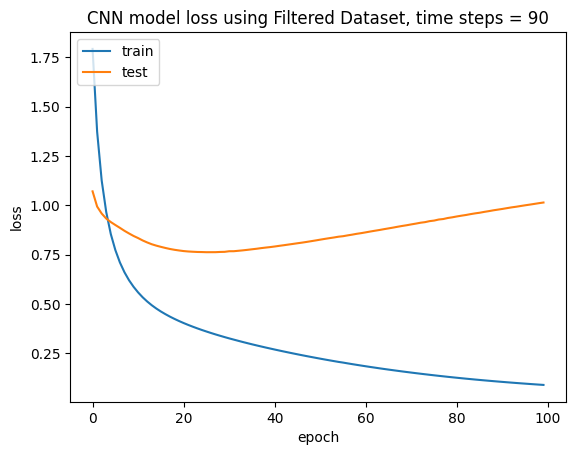

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss using Filtered Dataset, time steps = 90')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# Make predictions
predictions = cnn_model.predict(test_generator)  # Shape (n_samples, 1)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_test - predictions))

# # Mean Absolute Percentage Error (MAPE), handling division by zero
# y_true_nonzero = np.where(y_test != 0, y_test, 1e-10)  # Replace zero with a small value
# mape = np.mean(np.abs((y_test - predictions) / y_true_nonzero)) * 100  # MAPE in percentage

#  Mean Squared Error (MSE)
mse = np.mean((y_test - predictions) ** 2)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))

# Print metrics
print(f"Final Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Final Root Mean Square Error (RMSE): {round(rmse, 3)}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Final Mean Absolute Error (MAE): 0.839
Mean Squared Error (MSE): 1.117
Final Root Mean Square Error (RMSE): 1.057


In [21]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[time_steps:])], axis=1)
rev_trans = scaler.inverse_transform(df_pred)

In [22]:
df_pred.shape

(458, 8)

In [23]:
df_final = df[predictions.shape[0]*-1:]
df_final.count()

Power Generation (MW)                    458
Minimum Temperature (deg C)              458
Mean Temperature (deg C)                 458
Mean Dew Point Temperature (dec C)       458
Hargreaves Potential Evaporation (mm)    458
Eastward Wind Component (m/s)            458
Northward Wind Component (m/s)           458
Surface Pressure (kPa)                   458
dtype: int64

In [24]:
# Use .loc to explicitly assign values in the 'Forecasted Power Generation' column
df_final.loc[:, 'Forecasted Power Generation'] = rev_trans[:, 0]

C:\Users\User\AppData\Local\Temp\ipykernel_29796\2782822376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[:, 'Forecasted Power Generation'] = rev_trans[:, 0]


<Axes: title={'center': 'Hydropower Generation Forecasting using CNN'}>

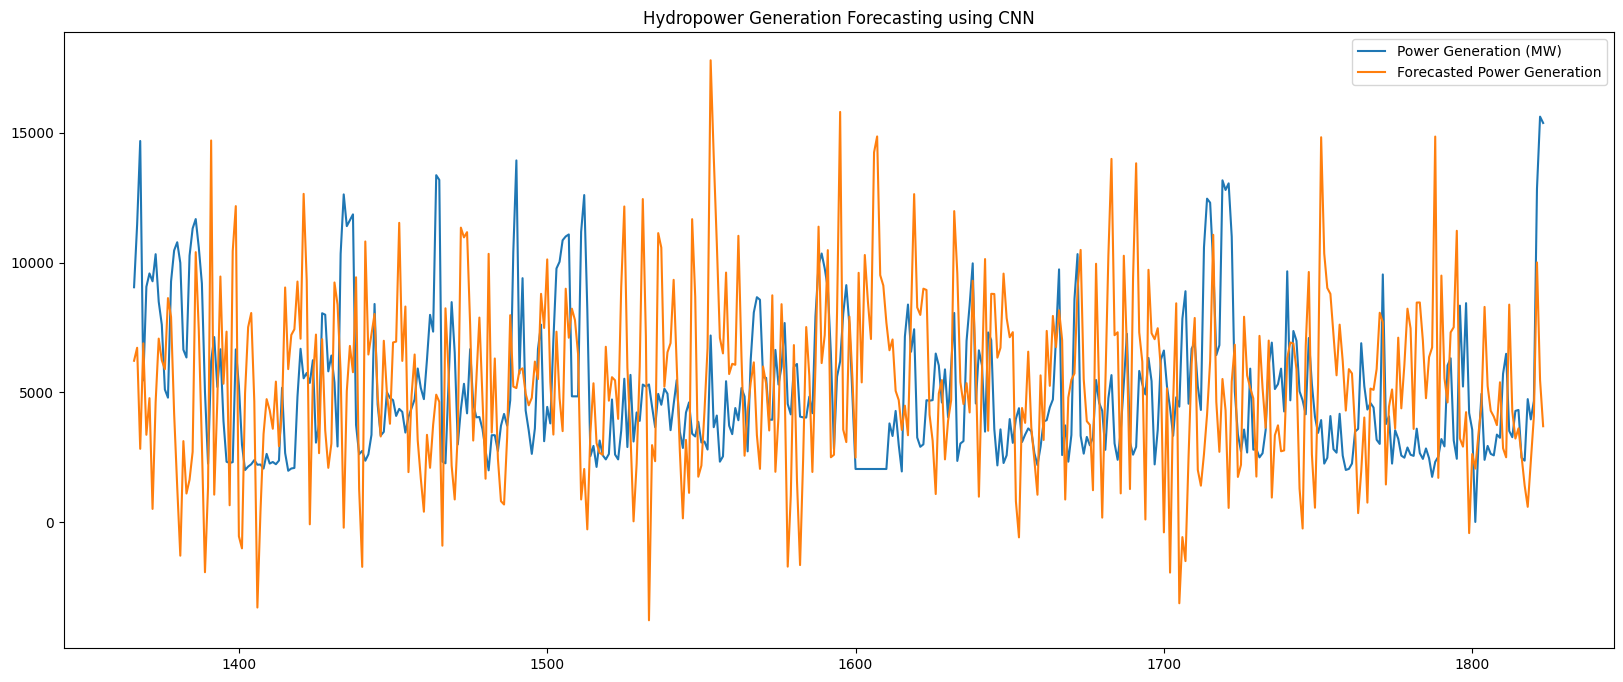

In [25]:
df_final[['Power Generation (MW)', 'Forecasted Power Generation']].plot(figsize=(20,8), title='Hydropower Generation Forecasting using CNN')